In [1]:
cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [2]:
from joblib import load
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from src.utils.joining import execute_join_with_aggregation

In [3]:
DEFAULT_QUERY_RESULT_DIR = Path("results/query_results")

In [4]:
def load_query_result(yadl_version, index_name, tab_name, query_column, top_k):
    query_result_path = "{}__{}__{}__{}.pickle".format(
        yadl_version,
        index_name,
        tab_name,
        query_column,
    )

    with open(Path(DEFAULT_QUERY_RESULT_DIR, query_result_path), "rb") as fp:
        query_result = pickle.load(fp)

    query_result.select_top_k(top_k)
    return query_result

In [5]:
data_lake_version = "wordnet_full"
index_names = ["exact_matching", "minhash", "minhash_hybrid"]
tabs = [
    "company_employees",
    "housing_prices",
    "movies_vote",
    "movies",
    "us_accidents",
    "us_county_population",
    "us_elections",
]
query_column = "col_to_embed"
top_k = 0

In [6]:
for iname in index_names:
    for tab in tabs:
        tab_name = f"{tab}-yadl-depleted"
        query_result = load_query_result(
            data_lake_version, iname, tab_name, query_column, top_k
        )
        print(iname, tab, query_result.n_candidates)

exact_matching company_employees 200
exact_matching housing_prices 200
exact_matching movies_vote 200
exact_matching movies 200
exact_matching us_accidents 200
exact_matching us_county_population 200
exact_matching us_elections 200
minhash company_employees 2292
minhash housing_prices 4113
minhash movies_vote 791
minhash movies 791
minhash us_accidents 5012
minhash us_county_population 4247
minhash us_elections 4247
minhash_hybrid company_employees 2292
minhash_hybrid housing_prices 4113
minhash_hybrid movies_vote 791
minhash_hybrid movies 791
minhash_hybrid us_accidents 5012
minhash_hybrid us_county_population 4247
minhash_hybrid us_elections 4247


In [7]:
import polars as pl
import numpy as np
import datetime

base_table = pl.read_parquet("data/source_tables/yadl/movies-yadl-depleted.parquet")

In [8]:
def measure_containment(base_table, left_on, candidate_table: pl.DataFrame, right_on):
    unique_src = base_table[left_on].unique()
    unique_cand = candidate_table[right_on].unique()
    s1 = set(unique_src[left_on].to_series().to_list())
    s2 = set(unique_cand[right_on].to_series().to_list())
    return len(s1.intersection(s2)) / len(s1)

In [9]:
def load_exact_matching(data_lake_version, table_name, column_name):
    path = Path("data/metadata/_indices", data_lake_version)
    iname = f"em_index_{table_name}_{column_name}.pickle"
    with open(Path(path, iname), "rb") as fp:
        d = load(fp)
    counts = d["counts"]
    return counts

In [30]:
def test_joining(
    data_lake_version, index_name, table_name, query_column, top_k, aggregation
):
    query_result = load_query_result(
        data_lake_version, index_name, table_name, query_column, 0
    )
    base_table = pl.read_parquet(f"data/source_tables/yadl/{table_name}.parquet")
    df_counts = load_exact_matching(
        data_lake_version=data_lake_version,
        table_name=table_name,
        column_name=query_column,
    )
    query_result.select_top_k(top_k)
    total_time = 0
    list_stats = []
    base_results = {
        "retrieval_method": index_name,
        "data_lake_version": data_lake_version,
        "table_name": table_name,
        "query_column": query_column,
        "aggregation": aggregation,
        "top_k": "",
        "rank": "",
        "cnd_table": "",
        "cnd_column": "",
        "containment": "",
        "src_nrows": "",
        "src_ncols": "",
        "cnd_nrows": "",
        "cnd_ncols": "",
        "join_time": "",
    }
    for rank, (c_id, cand) in enumerate(query_result.candidates.items()):
        r_dict = dict(base_results)
        _, cnd_md, left_on, right_on = cand.get_join_information()
        cand_table = pl.read_parquet(cnd_md["full_path"])

        cont = df_counts.filter(
            (pl.col("hash") == cnd_md["hash"]) & (pl.col("col") == right_on)
        )["containment"].item()

        start_time = datetime.datetime.now()
        merge = execute_join_with_aggregation(
            base_table,
            cand_table,
            left_on=left_on,
            right_on=right_on,
            how="left",
            aggregation=aggregation,
        )
        end_time = datetime.datetime.now()
        time_required = (end_time - start_time).total_seconds()
        total_time += time_required

        r_dict["cnd_table"] = cnd_md["hash"]
        r_dict["cnd_column"] = right_on[0]
        r_dict["containment"] = cont
        r_dict["src_nrows"], r_dict["src_ncols"] = base_table.shape
        r_dict["cnd_nrows"], r_dict["cnd_ncols"] = cand_table.shape
        r_dict["join_time"] = time_required
        r_dict["top_k"] = top_k
        r_dict["rank"] = rank

        list_stats.append(r_dict)
    print(f"{data_lake_version} {table_name} {aggregation} {top_k} {total_time:.2f}")
    return list_stats

In [73]:
index_names = ["exact_matching", "minhash", "minhash_hybrid"]
keys = ["index_name", "tab_name", "top_k", "join_time", "avg_cont"]
results = []
tabs = [
    "company_employees",
    "housing_prices",
    "movies_vote",
    "movies",
    "us_accidents",
    "us_county_population",
    "us_elections",
]

for tab in tabs:
    tab_name = f"{tab}-yadl-depleted"
    for i in index_names:
        print(i)
        for k in [10, 30, 100, 200]:
            for aggr in ["first", "mean"]:
                this_res = test_joining(data_lake_version, i, tab_name, query_column, k, aggregation=aggr)
                results+=this_res
            # break
df = pl.from_dicts(results)
df.write_parquet("analysis_query_results.csv")

exact_matching


/storage/workspace/tmp/ipykernel_47644/1254340447.py:39: DeprecationWarning: Behavior for `lit` will change for sequence inputs. The result will change to be a literal of type List. To retain the old behavior, pass a Series instead, e.g. `Series(sequence)`.
  (pl.col("hash") == cnd_md["hash"]) & (pl.col("col") == right_on)


wordnet_full company_employees-yadl-depleted first 10 0.21
wordnet_full company_employees-yadl-depleted mean 10 8.09
wordnet_full company_employees-yadl-depleted first 30 0.39
wordnet_full company_employees-yadl-depleted mean 30 19.24
wordnet_full company_employees-yadl-depleted first 100 0.85
wordnet_full company_employees-yadl-depleted mean 100 34.12
wordnet_full company_employees-yadl-depleted first 200 2.52
wordnet_full company_employees-yadl-depleted mean 200 124.13
minhash
wordnet_full company_employees-yadl-depleted first 10 0.08
wordnet_full company_employees-yadl-depleted mean 10 1.44
wordnet_full company_employees-yadl-depleted first 30 0.24
wordnet_full company_employees-yadl-depleted mean 30 6.22
wordnet_full company_employees-yadl-depleted first 100 0.64
wordnet_full company_employees-yadl-depleted mean 100 19.58
wordnet_full company_employees-yadl-depleted first 200 1.39
wordnet_full company_employees-yadl-depleted mean 200 41.32
minhash_hybrid
wordnet_full company_employ

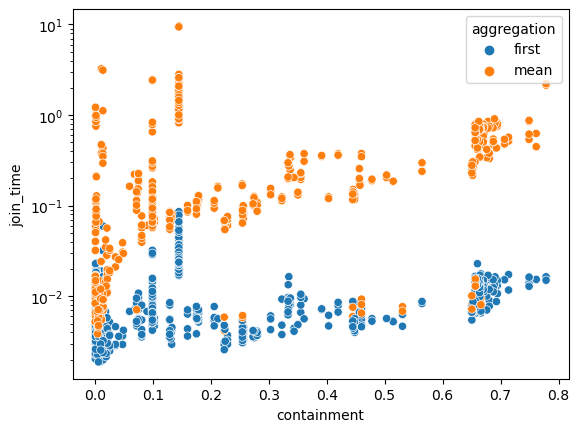

In [50]:
ax = sns.scatterplot(data=df.filter(pl.col("top_k") == 200).to_pandas(), x="containment", y="join_time", hue="aggregation")
ax.set_yscale("log")

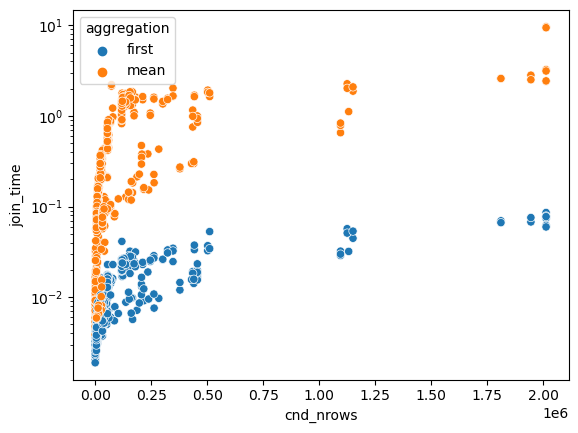

In [51]:
ax = sns.scatterplot(data=df.filter(pl.col("top_k") == 200).to_pandas(), x="cnd_nrows", y="join_time", hue="aggregation")
ax.set_yscale("log")

<Axes: xlabel='containment', ylabel='retrieval_method'>

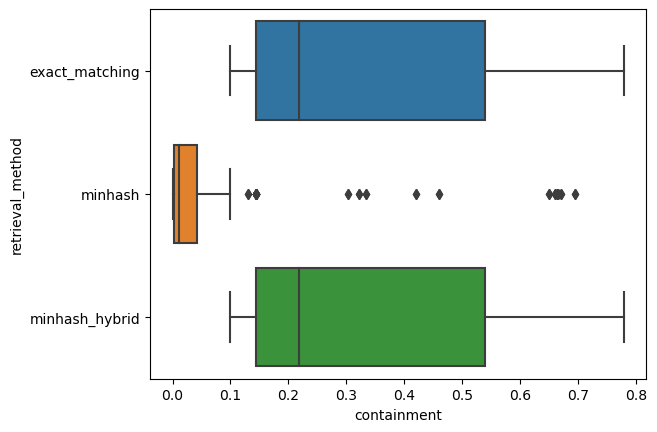

In [54]:
sns.boxplot(data=df.filter(pl.col("top_k") == 200).to_pandas(), x="containment", y="retrieval_method")

<Axes: xlabel='join_time', ylabel='retrieval_method'>

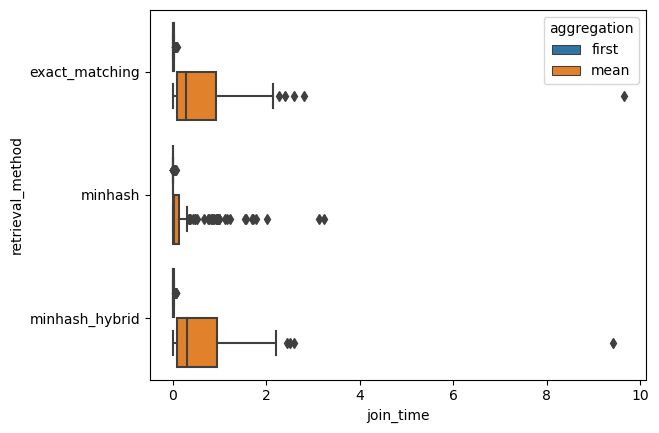

In [56]:
sns.boxplot(data=df.filter(pl.col("top_k") == 200).to_pandas(), x="join_time", y="retrieval_method", hue="aggregation")

In [37]:
df_agg = df.group_by(
    ["retrieval_method", "data_lake_version", "table_name", "query_column", "aggregation", "top_k"]
).agg(
    pl.col("containment").mean().alias("avg_containment"),
    pl.col("containment").median().alias("median_containment"),
    pl.col("cnd_nrows").mean().alias("avg_cnd_nrows"),
    pl.col("cnd_nrows").median().alias("median_cnd_nrows"),
    pl.col("join_time").mean().alias("avg_join_time"),
    pl.col("join_time").median().alias("median_join_time"),
).sort("retrieval_method", "table_name")

In [57]:
df_agg

retrieval_method,data_lake_version,table_name,query_column,aggregation,top_k,avg_containment,median_containment,avg_cnd_nrows,median_cnd_nrows,avg_join_time,median_join_time
str,str,str,str,str,i64,f64,f64,f64,f64,f64,f64
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""mean""",10,0.722615,0.710307,58914.6,58400.0,0.8088441,0.658953
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""mean""",30,0.688848,0.679453,52925.633333,54943.5,0.6562324,0.642303
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",200,0.322091,0.217645,125087.67,38712.5,0.013663,0.008895
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",100,0.510424,0.547532,31062.86,27260.0,0.00907,0.00796
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""mean""",200,0.322091,0.217645,125087.67,38712.5,0.624126,0.284526
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""mean""",100,0.510424,0.547532,31062.86,27260.0,0.352016,0.2805025
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",10,0.722615,0.710307,58914.6,58400.0,0.016254,0.016114
"""exact_matching…","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",30,0.688848,0.679453,52925.633333,54943.5,0.013953,0.0145955
"""minhash""","""wordnet_full""","""company_employ…","""col_to_embed""","""first""",30,0.059773,0.02018,87767.533333,10436.0,0.007796,0.004364


In [59]:
df.write_csv("results_indexing_time_cont.csv")

In [70]:
ddf=df_agg.melt(
    id_vars=["retrieval_method", "aggregation", "top_k"],value_vars=["median_containment", "avg_join_time"]
)

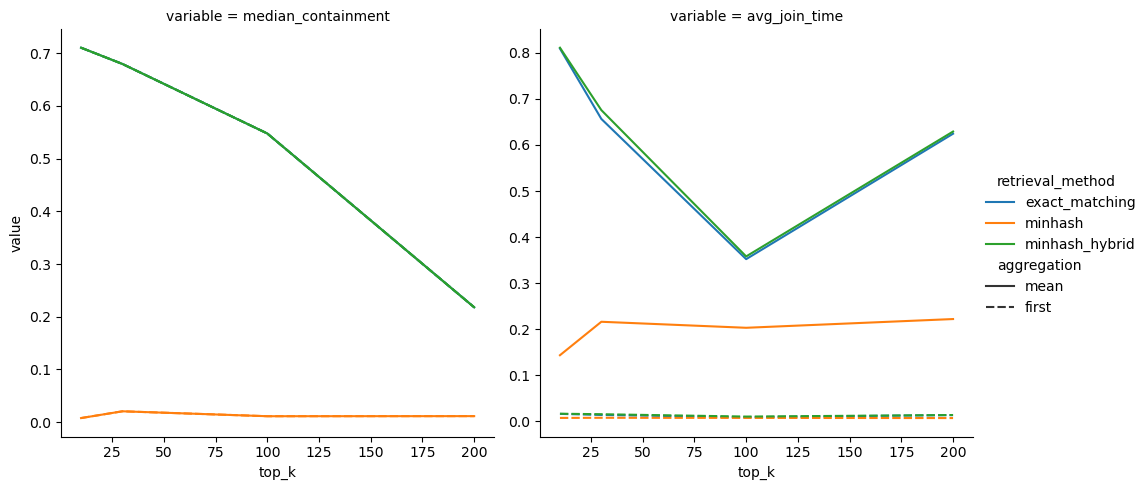

In [71]:
sns.relplot(data=ddf, x="top_k", y="value", hue="retrieval_method", col="variable", kind="line", facet_kws={"sharey":False}, style='aggregation')

In [7]:
with open(
    "/home/soda/rcappuzz/work/benchmark-join-suggestions/data/metadata/_indices/wordnet_full/em_index_company_employees-yadl_col_to_embed.pickle",
    "rb",
) as fp:
    d = load(fp)

In [8]:
d

{'index_name': 'exact_matching',
 'metadata_dir': PosixPath('data/metadata/wordnet_full'),
 'base_table_path': PosixPath('data/source_tables/batch/company-employees-yadl.parquet'),
 'query_column': 'col_to_embed',
 'counts': shape: (83_474, 3)
 ┌──────────────────────────────────┬────────────────────────────┬─────────────┐
 │ hash                             ┆ col                        ┆ containment │
 │ ---                              ┆ ---                        ┆ ---         │
 │ str                              ┆ str                        ┆ f64         │
 ╞══════════════════════════════════╪════════════════════════════╪═════════════╡
 │ 20d3c463551bdff4ad1fa3865652547e ┆ wordnet_company_108058098  ┆ 0.778519    │
 │ bb07025128e44666f1f9ca30f99a94f8 ┆ wordnet_company_108058098  ┆ 0.761508    │
 │ 6aa1967be2d07436fbd61c354bf5a239 ┆ wordnet_company_108058098  ┆ 0.749166    │
 │ 3d1c4969f30b40b8cfadbd934fe73178 ┆ wordnet_company_108058098  ┆ 0.749166    │
 │ …                       